In [76]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import logging
import pandas as pd
import numpy as np
import scipy
import yaml
import matplotlib.pyplot as plt

sys.path.append('../')

from abacus.auto_ab.abtest import ABTest
from abacus.auto_ab.params import ABTestParams
from abacus.auto_ab.params import DataParams, HypothesisParams
from abacus.splitter.split_builder import SplitBuilder
from abacus.splitter.params import SplitBuilderParams
from abacus.mde_researcher.params import MdeParams
from abacus.mde_researcher.mde_research_builder import MdeResearchBuilder
from abacus.mde_researcher.multiple_split_builder import MultipleSplitBuilder


logging.basicConfig(level = logging.INFO)


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Данные, с которыми будем работать

In [2]:
pd.read_csv('./data/ab_data.csv').head()

,height_now,height_prev,weight_now,weight_prev,noise_now,noise_prev,groups,id,moda_city,country,numerator,denominator,conversion
0,172.470442,166.382868,163.648256,173.422115,5.644384,-1.923929,A,0,3,2,3,2,1
1,178.610565,173.386388,173.195935,180.831845,11.664751,2.711829,B,1,2,2,1,4,1
2,180.382301,178.563579,174.520065,181.571024,7.183178,-0.453939,A,2,3,1,2,2,1
3,180.954018,179.732080,175.731245,182.840388,-4.682656,6.358723,B,3,4,1,3,2,0
4,167.590042,167.684244,166.109779,170.189261,9.134517,-1.153977,B,4,2,1,3,2,1


# Кейс №1. Постанализ непрерывной метрики.

In [3]:
df = pd.read_csv('./data/ab_data.csv')

In [4]:
data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    strata_col='country', 
    target='height_now', 
    target_flg='bought', 
    predictors=['weight_now'], 
    numerator='clicks', 
    denominator='sessions', 
    covariate='height_prev', 
    target_prev='height_prev', 
    predictors_prev=['weight_prev'], 
    is_grouped=True
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided', 
    strata='country', 
    strata_weights={1: 0.8, 2: 0.2}, 
    metric_type='solid', 
    metric_name='mean', 
    metric=np.mean, 
    n_boot_samples=100, 
    n_buckets=50
)

ab_params = ABTestParams(data_params, hypothesis_params)

In [5]:
ab_test = ABTest(df, ab_params)

In [6]:
print('Нет эффекта:\n')

print(f"bootstrap_test: {ab_test.test_boot_confint()}")
print(f"mannwhitney_test: {ab_test.test_mannwhitney()}")
print(f"welch_test: {ab_test.test_welch()}")

Нет эффекта:

bootstrap_test: {'stat': None, 'p-value': 0.2955558396725629, 'result': 0}
mannwhitney_test: {'stat': 4992976857.0, 'p-value': 0.5890975776571467, 'result': 0}
welch_test: {'stat': 0.4435517988023507, 'p-value': 0.6573671411499618, 'result': 0}


Увеличиваем количество прокрасов в тестовой группе

In [880]:
df[ab_test.params.data_params.target].where(df[ab_test.params.data_params.group_col] == 'A',
                                            df[ab_test.params.data_params.target] * 1.001, 
                                            axis=0,
                                            inplace=True)

ab_test = ABTest(df, ab_params)

In [881]:
print('Есть эффект:')
print(f"bootstrap_test: {ab_test.test_boot_confint()}")
print(f"mannwhitney_test: {ab_test.test_mannwhitney()}")
print(f"welch_test: {ab_test.test_welch()}")

Есть эффект:
bootstrap_test: {'stat': None, 'p-value': 2.9000684250165774e-19, 'result': 1}
mannwhitney_test: {'stat': 4894119324.0, 'p-value': 2.4516264484905984e-16, 'result': 1}
welch_test: {'stat': -8.275588883468059, 'p-value': 1.2859564365137272e-16, 'result': 1}


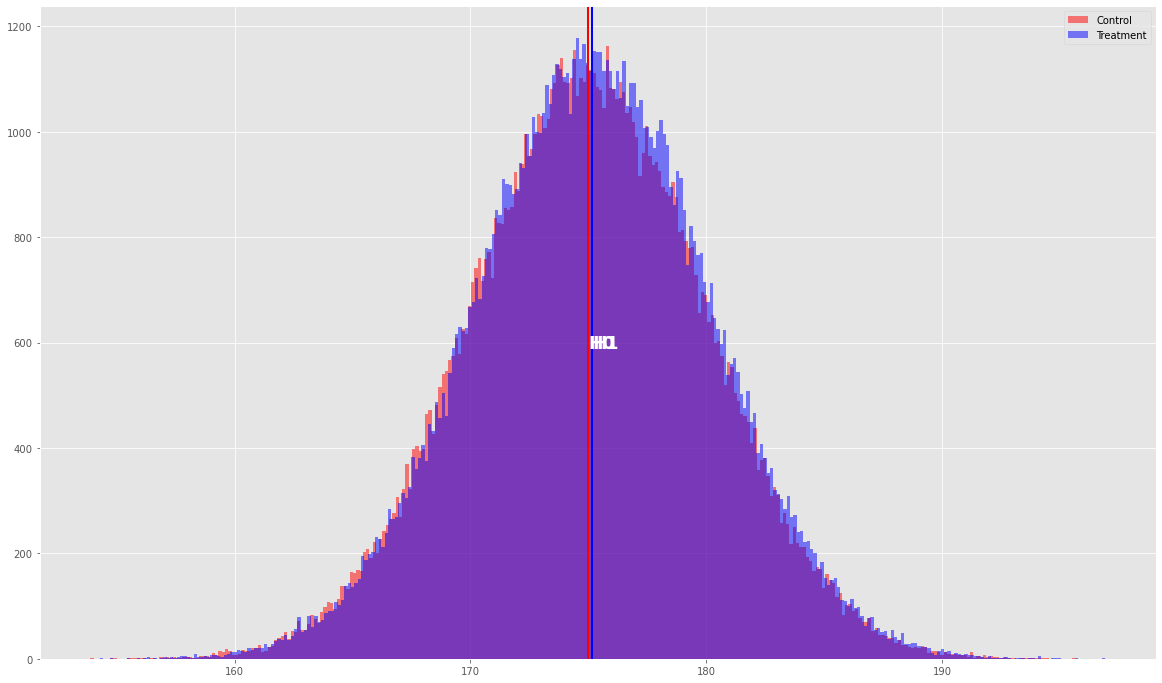

In [858]:
ab_test.plot()

## Кейс №1.1. Постанализ непрерывной метрики с бакетированием.

In [348]:
df = pd.read_csv('./data/ab_data.csv')
df['height_now'] = np.random.lognormal(1, 0.5, df.shape[0])

In [365]:
data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    strata_col='country', 
    target='height_now', 
    target_flg='bought', 
    predictors=['weight_now'], 
    numerator='clicks', 
    denominator='sessions', 
    covariate='height_prev', 
    target_prev='height_prev', 
    predictors_prev=['weight_prev'], 
    is_grouped=True
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided', 
    strata='country', 
    strata_weights={1: 0.8, 2: 0.2}, 
    metric_type='solid', 
    metric_name='mean', 
    metric=np.mean, 
    n_boot_samples=100, 
    n_buckets=500
)

ab_params = ABTestParams(data_params, hypothesis_params)

In [366]:
ab_test = ABTest(df, ab_params)
print(ab_test.test_welch())

{'stat': -0.6506597148687806, 'p-value': 0.5152669211535506, 'result': 0}


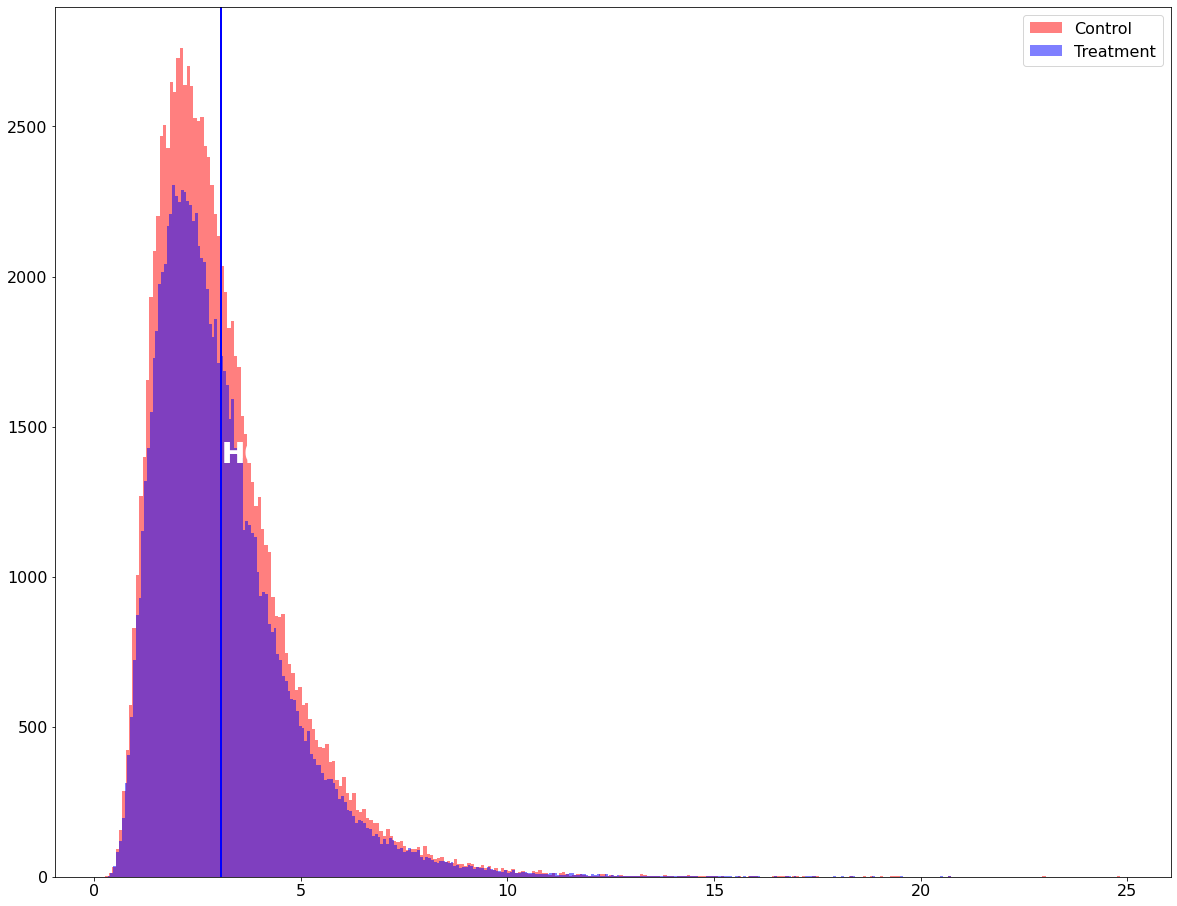

In [374]:
ab_test.plot()

In [368]:
print(len(ab_test.params.data_params.control))

99684


In [369]:
ab_test_11 = ab_test.bucketing()
print(len(ab_test_11.params.data_params.control))

500


In [370]:
print(ab_test_11.test_welch())

{'stat': -0.6353478931178687, 'p-value': 0.5253478025867957, 'result': 0}


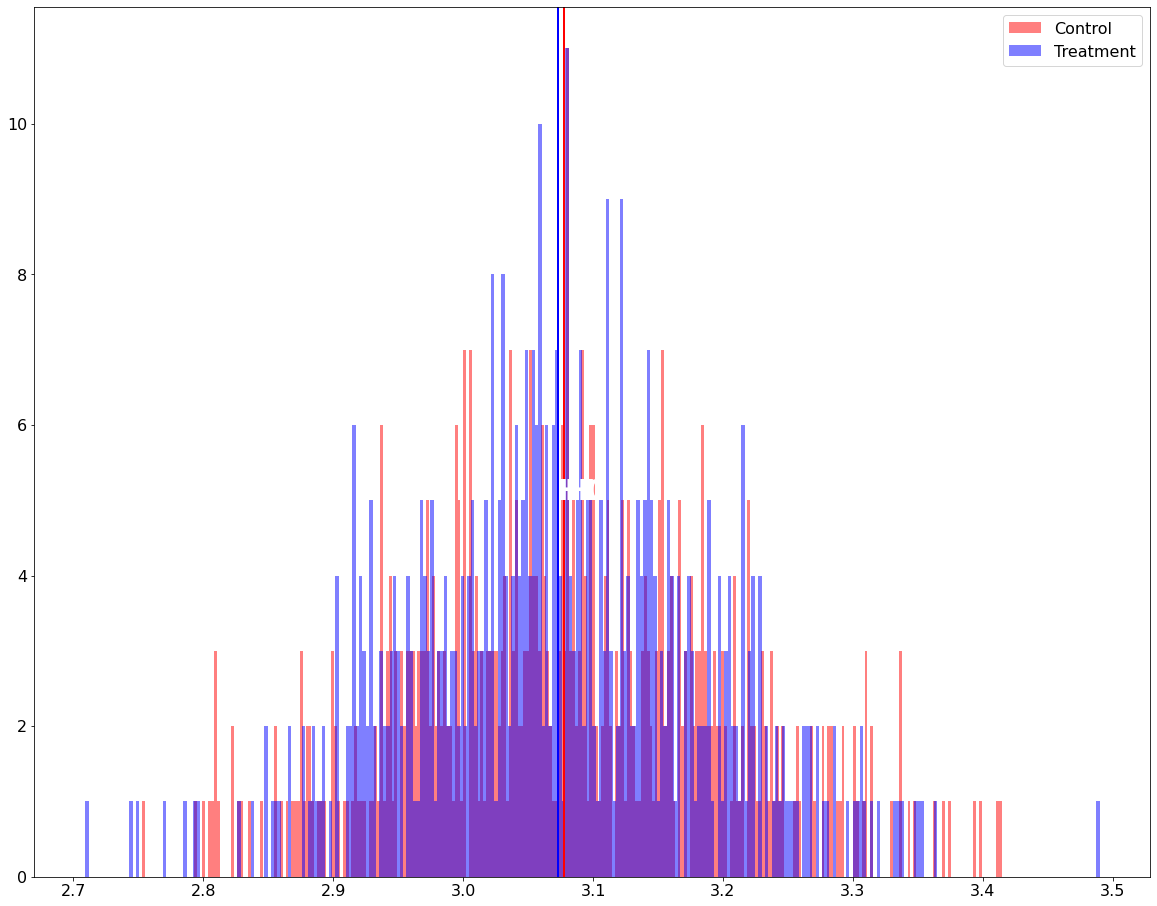

In [373]:
ab_test_11.plot()

In [372]:
scipy.stats.shapiro(ab_test_11.params.data_params.control)

ShapiroResult(statistic=0.9968929290771484, pvalue=0.4576939344406128)

# Кейс №2. Постанализ с увеличением чувствительности непрерывной метрики. CUPED.

In [4]:
df = pd.read_csv('./data/ab_data.csv')

In [8]:
data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    strata_col='country', 
    target='height_now', 
    target_flg='bought', 
    predictors=['weight_now'], 
    numerator='clicks', 
    denominator='sessions', 
    covariate='height_prev', 
    target_prev='height_prev', 
    predictors_prev=['weight_prev'], 
    is_grouped=False
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided', 
    strata='country', 
    strata_weights={1: 0.8, 2: 0.2}, 
    metric_type='solid', 
    metric_name='mean', 
    metric=np.mean, 
    n_boot_samples=100, 
    n_buckets=50
)

ab_params = ABTestParams(data_params, hypothesis_params)
ab_test = ABTest(df, ab_params)

Увеличиваем количество прокрасов в тестовой группе

In [10]:
df[ab_test.params.data_params.target].where(df[ab_test.params.data_params.group_col] == 'A',
                                            df[ab_test.params.data_params.target] * 1.0001, 
                                            axis=0,
                                            inplace=True)

print('Без понижения дисперсии:')
print(f"bootstrap_test: {ab_test.test_boot_confint()}")
print(f"mannwhitney_test: {ab_test.test_mannwhitney()}")
print(f"ttest_test: {ab_test.test_welch()}")

print('\nС понижением дисперсии:')
ab_test1 = ab_test.cuped()
print(f"bootstrap_test: {ab_test1.test_boot_confint()}")
print(f"mannwhitney_test: {ab_test1.test_mannwhitney()}")
print(f"ttest_test: {ab_test1.test_welch()}")

Без понижения дисперсии:
bootstrap_test: {'stat': None, 'p-value': 0.2953382345292215, 'result': 0}
mannwhitney_test: {'stat': 4992976857.0, 'p-value': 0.5890975776571467, 'result': 0}
ttest_test: {'stat': -0.4435517988023507, 'p-value': 0.6573671411499618, 'result': 0}

С понижением дисперсии:
bootstrap_test: {'stat': None, 'p-value': 1.7959757670645774e-10, 'result': 1}
mannwhitney_test: {'stat': 4935929755.0, 'p-value': 7.085523339105924e-07, 'result': 1}
ttest_test: {'stat': -5.427345848449324, 'p-value': 5.726445548534407e-08, 'result': 1}


# Кейс №3. Постанализ для бинарной метрики.

In [378]:
df = pd.read_csv('./data/ab_data.csv')

In [379]:
data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    strata_col='country',
    target='conversion', 
    target_flg='conversion', 
    predictors=['weight_now'], 
    numerator='numerator', 
    denominator='denominator', 
    covariate='height_prev', 
    target_prev='height_prev', 
    predictors_prev=['weight_prev'], 
    is_grouped=True
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided', 
    strata='country', 
    strata_weights={'1': 0.8, '2': 0.2}, 
    metric_type='binary', 
    metric_name='mean', 
    metric='mean', 
    n_boot_samples=200, 
    n_buckets=50
)

ab_params = ABTestParams(data_params, hypothesis_params)

In [380]:
ab_test = ABTest(df, ab_params)

In [381]:
print('Нет эффекта:')
print(f"bootstrap_binary_test: {ab_test.test_boot_ratio()}")
print(f"z_proportions_test: {ab_test.test_z_proportions()}")

Нет эффекта:
bootstrap_binary_test: {'stat': None, 'p-value': None, 'result': 0}
z_proportions_test: {'stat': -0.6730634505952151, 'p-value': 0.500906925062246, 'result': 0}


Увеличиваем количество прокрасов в тестовой группе

In [382]:
df['conversion'] = np.where(df.noise_now < 0, 0, 1)
df[ab_test.params.data_params.target].where(df[ab_test.params.data_params.group_col] == 'A',
                                            np.random.binomial(n=1, p=0.72, size=df.shape[0]),
                                            axis=0,
                                            inplace=True)

ab_test = ABTest(df, ab_params)

print('Есть эффект:')
print(f"bootstrap_binary_test: {ab_test.test_boot_ratio()}")
print(f"z_proportions_test: {ab_test.test_z_proportions()}")

Есть эффект:
bootstrap_binary_test: {'stat': None, 'p-value': None, 'result': 0}
z_proportions_test: {'stat': 140.19472707126954, 'p-value': 0.0, 'result': 1}


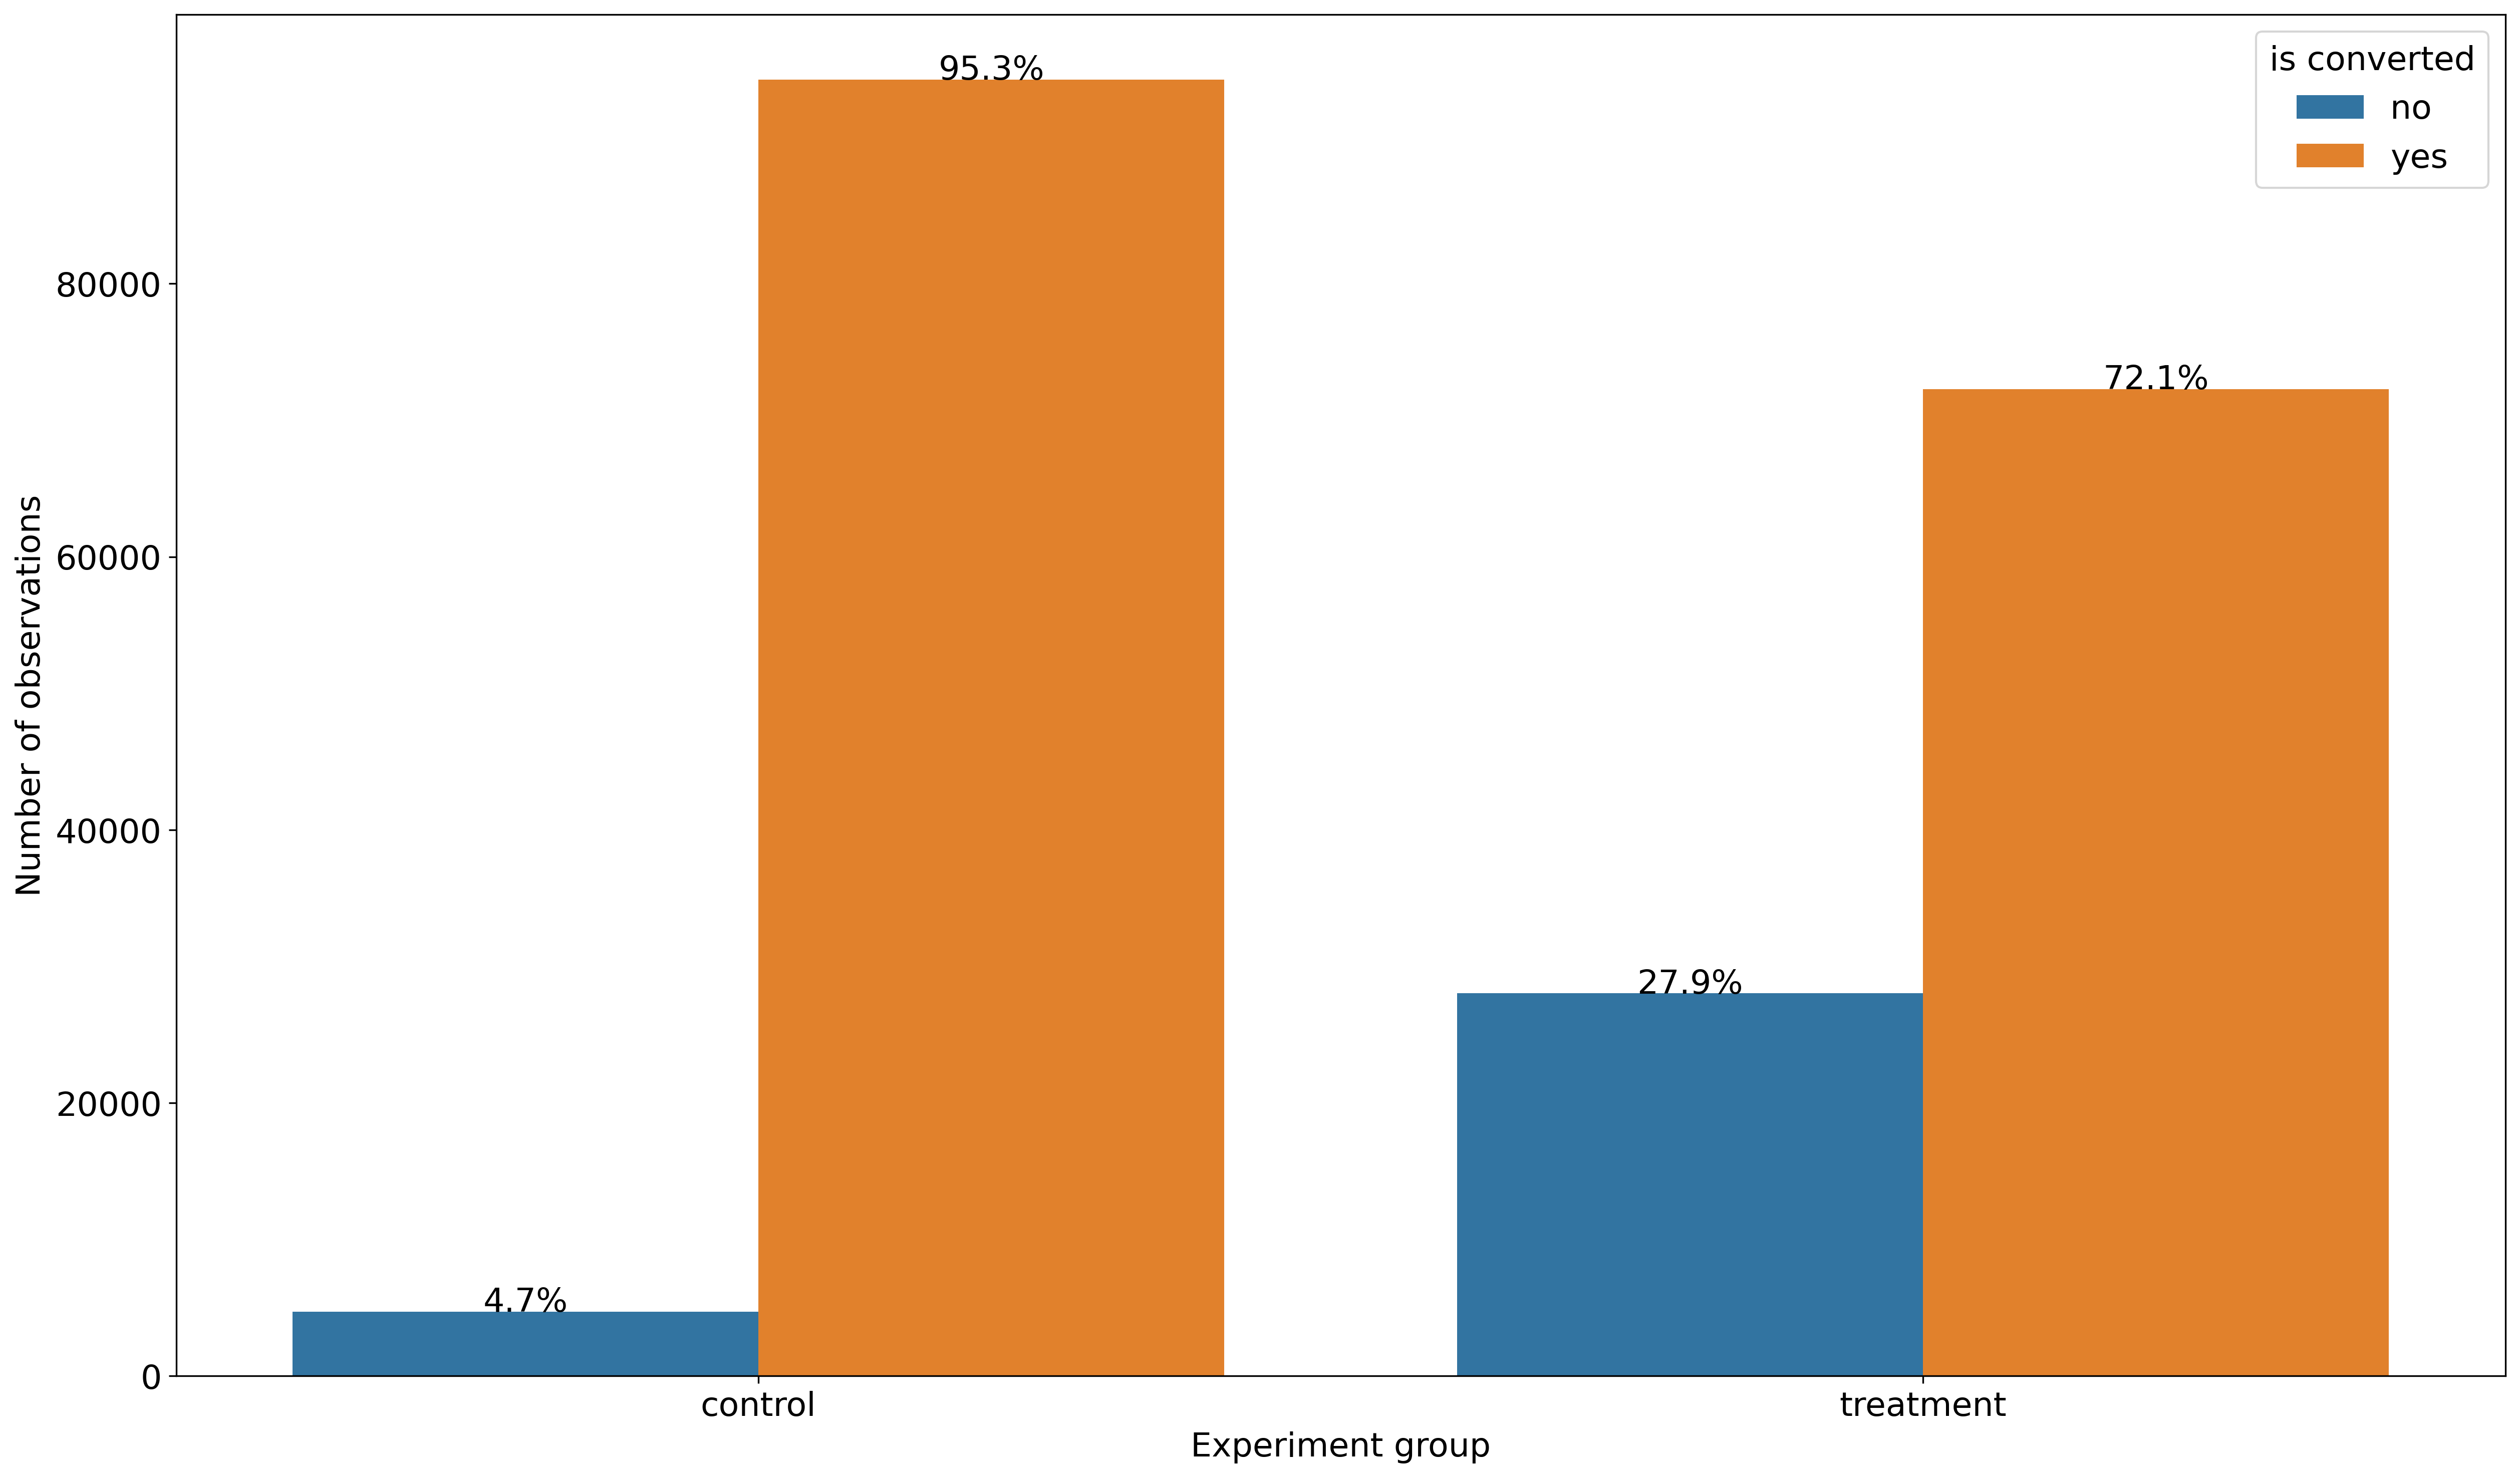

In [388]:
ab_test.plot()

# Кейс №4. Постанализ с увеличением чувствительности бинарной метрики. CUPED.

<span style="color: red;">CUPED работает только с непрерывными метриками!</span>

In [485]:
df = pd.read_csv('./data/ab_data.csv')

In [486]:
data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    strata_col='country', 
    target='height_now', 
    target_flg='conversion', 
    predictors=['weight_now'], 
    numerator='numerator', 
    denominator='denominator', 
    covariate='height_prev', 
    target_prev='height_prev', 
    predictors_prev=['weight_prev'], 
    is_grouped=True
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided', 
    strata='country', 
    strata_weights={1: 0.8, 2: 0.2}, 
    metric_type='binary', 
    metric_name='mean', 
    metric=np.mean, 
    n_boot_samples=100, 
    n_buckets=50
)

ab_params = ABTestParams(data_params, hypothesis_params)

In [487]:
ab_test = ABTest(df, ab_params)
print('Нет эффекта:')
print(f"bootstrap_binary_test: {ab_test.test_boot_confint()}")
print(f"z_proportions_test: {ab_test.test_z_proportions()}")

ab_test1 = ab_test.cuped()
print('\nТоже нет эффекта!')
print(f"bootstrap_binary_test: {ab_test1.test_boot_confint()}")
print(f"z_proportions_test: {ab_test1.test_z_proportions()}")

Нет эффекта:
bootstrap_binary_test: {'stat': None, 'p-value': 0.2923214192832334, 'result': 0}
z_proportions_test: {'stat': -0.6730634505952151, 'p-value': 0.500906925062246, 'result': 0}

Тоже нет эффекта!
bootstrap_binary_test: {'stat': None, 'p-value': 0.16191091548864112, 'result': 0}
z_proportions_test: {'stat': -0.6730634505952151, 'p-value': 0.500906925062246, 'result': 0}


# Кейс №5. CUPED.
## Кейс №5.1. Различий между групп нет.

In [16]:
df = pd.read_csv('./data/ab_data.csv')

In [193]:
data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    strata_col='country', 
    target='height_now', 
    target_flg='bought', 
    predictors=['weight_now'], 
    numerator='clicks', 
    denominator='sessions', 
    covariate='height_prev', 
    target_prev='height_prev', 
    predictors_prev=['weight_prev'], 
    is_grouped=True
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided', 
    strata='country', 
    strata_weights={1: 0.8, 2: 0.2}, 
    metric_type='solid', 
    metric_name='mean', 
    metric=np.mean, 
    n_boot_samples=100, 
    n_buckets=50
)

ab_params = ABTestParams(data_params, hypothesis_params)

In [18]:
ab_test = ABTest(df, ab_params)

In [19]:
print('Control mean = {:.3f}'.format(np.mean(ab_test.params.data_params.control)))
print('Treatment mean = {:.3f}'.format(np.mean(ab_test.params.data_params.treatment)))
print('Control var = {:.3f}'.format(np.var(ab_test.params.data_params.control)))
print('Treatment var = {:.3f}'.format(np.var(ab_test.params.data_params.treatment)))

Control mean = 174.990
Treatment mean = 175.000
Control var = 24.972
Treatment var = 24.900


In [20]:
print('Различий нет:')
print(f"bootstrap_test: {ab_test.test_boot_confint()}")
print(f"mannwhitney_test: {ab_test.test_mannwhitney()}")
print(f"ttest_test: {ab_test.test_welch()}")

bootstrap_test: {'stat': None, 'p-value': 0.3256258370999519, 'result': 0}
mannwhitney_test: {'stat': 4992976857.0, 'p-value': 0.5890975776571467, 'result': 0}
ttest_test: {'stat': 0.4435517988023507, 'p-value': 0.6573671411499618, 'result': 0}


Применяем CUPED:

In [493]:
ab_test1 = ab_test.cuped()

In [494]:
print('Control mean = {:.3f}'.format(np.mean(ab_test1.params.data_params.control)))
print('Treatment mean = {:.3f}'.format(np.mean(ab_test1.params.data_params.treatment)))
print('Control var = {:.3f}'.format(np.var(ab_test1.params.data_params.control)))
print('Treatment var = {:.3f}'.format(np.var(ab_test1.params.data_params.treatment)))

Control mean = 174.990
Treatment mean = 175.000
Control var = 3.417
Treatment var = 3.428


In [495]:
print('Если различий нет, то CUPED и не поможет их найти:')
print(f"bootstrap_test: {ab_test1.test_boot_confint()}")
print(f"mannwhitney_test: {ab_test1.test_mannwhitney()}")
print(f"ttest_test: {ab_test1.test_welch()}")

Если различий нет, то CUPED и не поможет их найти:
bootstrap_test: {'stat': None, 'p-value': 0.15211813381716005, 'result': 0}
mannwhitney_test: {'stat': 4989318477.0, 'p-value': 0.4102113130399977, 'result': 0}
ttest_test: {'stat': -1.19727175900244, 'p-value': 0.2312020672817067, 'result': 0}


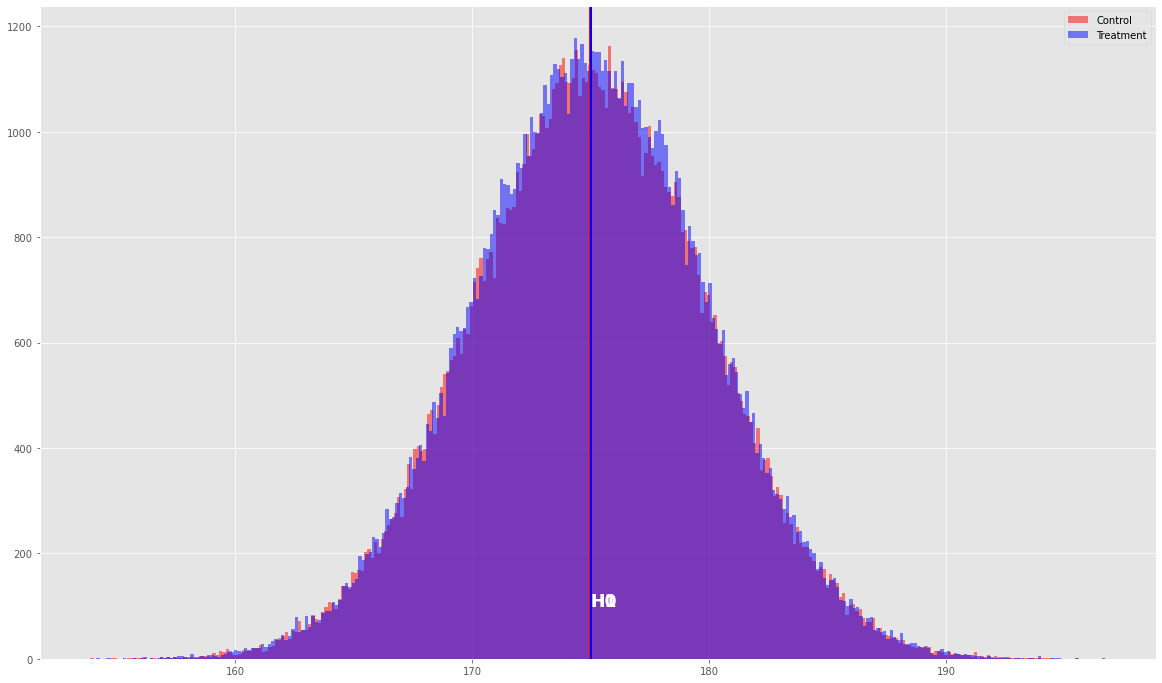

In [496]:
ab_test.plot()

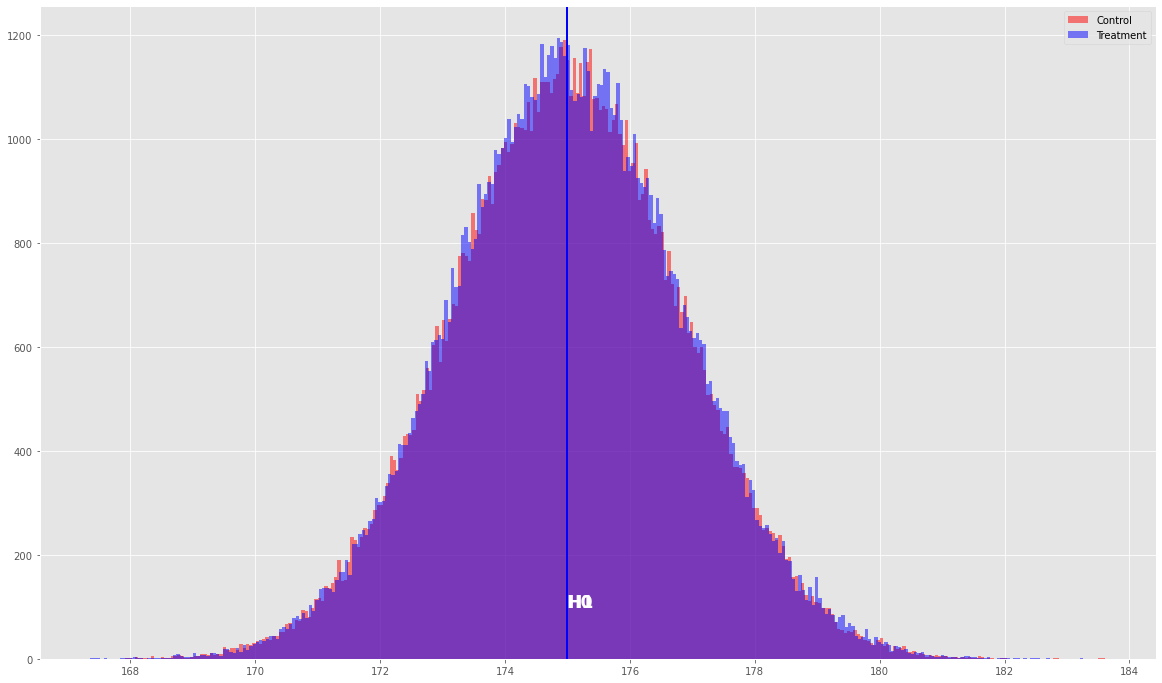

In [497]:
ab_test1.plot()

## Кейс №5.2. Различия между группами есть.

### Увеличиваем значения одной из групп.

In [184]:
df = pd.read_csv('./data/ab_data.csv')

incs = np.random.uniform(0.0, 0.009, df.shape[0])
df['height_now'].where(df[ab_test.params.data_params.group_col]=='A',
                                    df['height_now'] + incs, 
                                    axis=0,
                                    inplace=True)

In [185]:
data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    strata_col='country', 
    target='height_now', 
    target_flg='bought', 
    predictors=['weight_now'], 
    numerator='clicks', 
    denominator='sessions', 
    covariate='height_prev', 
    target_prev='height_prev', 
    predictors_prev=['weight_prev'], 
    is_grouped=True
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='greater', 
    strata='country', 
    strata_weights={1: 0.8, 2: 0.2}, 
    metric_type='solid', 
    metric_name='mean', 
    metric=np.mean, 
    n_boot_samples=100, 
    n_buckets=50
)

ab_params = ABTestParams(data_params, hypothesis_params)

In [186]:
ab_test = ABTest(df, ab_params)

In [187]:
print('Control mean = {:.3f}'.format(np.mean(ab_test.params.data_params.control)))
print('Treatment mean = {:.3f}'.format(np.mean(ab_test.params.data_params.treatment)))
print('Control var = {:.3f}'.format(np.var(ab_test.params.data_params.control)))
print('Treatment var = {:.3f}'.format(np.var(ab_test.params.data_params.treatment)))

Control mean = 174.990
Treatment mean = 175.004
Control var = 24.972
Treatment var = 24.900


In [188]:
print('Различий нет:\n')

print(f"bootstrap_test: {ab_test.test_boot_confint()}")
print(f"mannwhitney_test: {ab_test.test_mannwhitney()}")
print(f"ttest_test: {ab_test.test_welch()}")

Различий нет:

bootstrap_test: {'stat': None, 'p-value': 0.7401035196755457, 'result': 0}
mannwhitney_test: {'stat': 4990439915.0, 'p-value': 0.7693340530775314, 'result': 0}
ttest_test: {'stat': 0.6449649167248743, 'p-value': 0.25947533058051253, 'result': 0}


Применяем CUPED:

In [190]:
ab_test2 = ab_test.cuped()

In [191]:
print('Control mean = {:.3f}'.format(np.mean(ab_test2.params.data_params.control)))
print('Treatment mean = {:.3f}'.format(np.mean(ab_test2.params.data_params.treatment)))
print('Control var = {:.3f}'.format(np.var(ab_test2.params.data_params.control)))
print('Treatment var = {:.3f}'.format(np.var(ab_test2.params.data_params.treatment)))

Control mean = 174.990
Treatment mean = 175.004
Control var = 3.417
Treatment var = 3.428


In [192]:
print('Если различия есть, то CUPED может помочь их найти:\n')

print(f"bootstrap_test: {ab_test2.test_boot_confint()}")
print(f"mannwhitney_test: {ab_test2.test_mannwhitney()}")
print(f"ttest_test: {ab_test2.test_welch()}")

Если различия есть, то CUPED может помочь их найти:

bootstrap_test: {'stat': None, 'p-value': 0.9627498013445376, 'result': 1}
mannwhitney_test: {'stat': 4982459719.0, 'p-value': 0.9122594098757563, 'result': 0}
ttest_test: {'stat': 1.7409443939187592, 'p-value': 0.040847431905294586, 'result': 1}


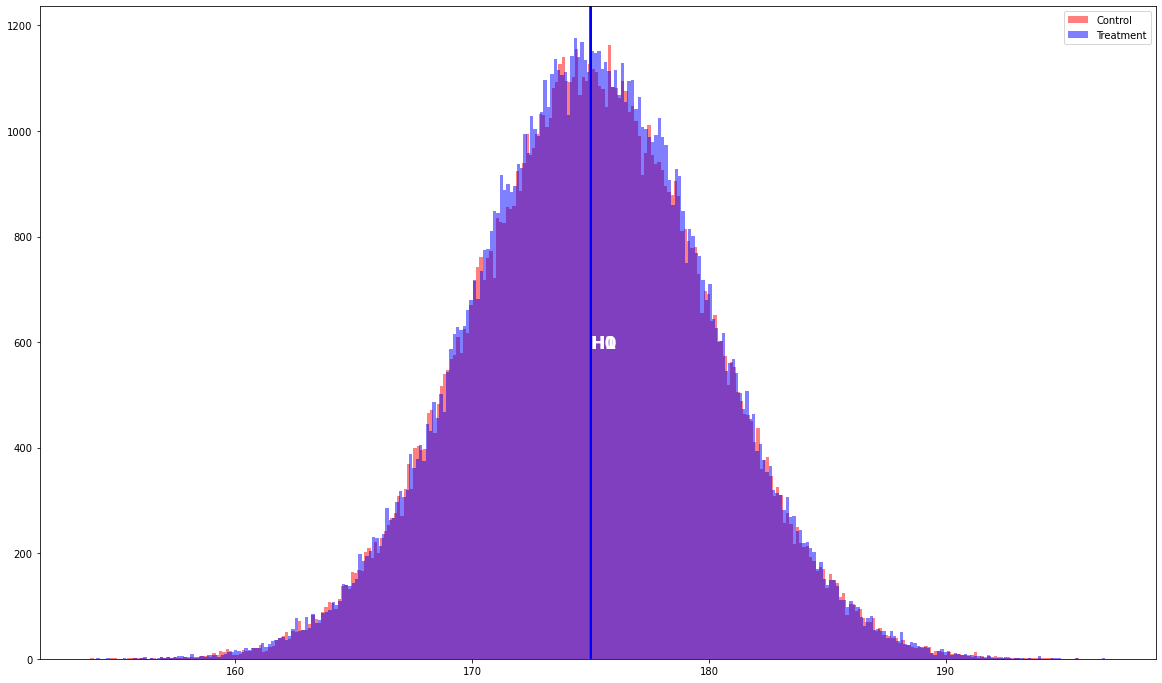

In [193]:
ab_test.plot()

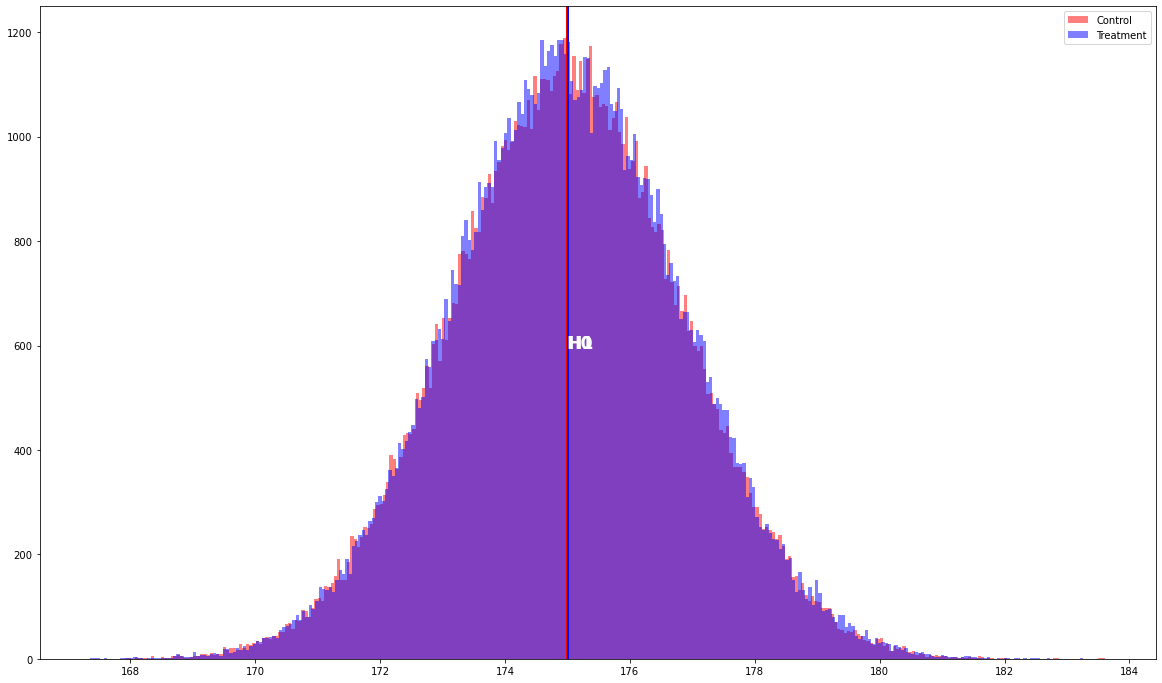

In [194]:
ab_test2.plot()

# Кейс №6. Всё вместе: chaining rule & reporting.

In [85]:
df = pd.read_csv('./data/ab_data.csv')
df.head()

,height_now,height_prev,weight_now,weight_prev,noise_now,noise_prev,groups,id,moda_city,country,numerator,denominator,conversion
0,172.470442,166.382868,163.648256,173.422115,5.644384,-1.923929,A,0,3,2,3,2,1
1,178.610565,173.386388,173.195935,180.831845,11.664751,2.711829,B,1,2,2,1,4,1
2,180.382301,178.563579,174.520065,181.571024,7.183178,-0.453939,A,2,3,1,2,2,1
3,180.954018,179.732080,175.731245,182.840388,-4.682656,6.358723,B,3,4,1,3,2,0
4,167.590042,167.684244,166.109779,170.189261,9.134517,-1.153977,B,4,2,1,3,2,1


In [92]:
data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    strata_col='country', 
    target='height_now', 
    target_flg='bought', 
    predictors=['weight_now'], 
    numerator='clicks', 
    denominator='sessions', 
    covariate='height_prev', 
    target_prev='height_prev', 
    predictors_prev=['weight_prev'], 
    is_grouped=False
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided', 
    strata='country', 
    strata_weights={1: 0.8, 2: 0.2}, 
    metric_type='solid', 
    metric_name='mean', 
    metric=np.mean, 
    n_boot_samples=100, 
    n_buckets=2000
)

ab_params = ABTestParams(data_params, hypothesis_params)

In [93]:
df = pd.read_csv('./data/ab_data.csv')
df['height_now'].where(df['groups'] == 'A',
                       df['height_now'] * 1.003,
                       axis=0,
                       inplace=True)
df['id'] = np.random.randint(0, 150_000, df.shape[0])
df = df.drop_duplicates(['id'])

In [94]:
ab_test = ABTest(df, ab_params).linearization().cuped().bucketing()
ab_test.params.data_params.transforms

array(['linearization', 'cuped', 'bucketing'], dtype='<U32')

In [95]:
ab_test.test_welch()

{'stat': 46.78522734478731, 'p-value': 0.0, 'result': 1}

In [96]:
ab_test.report()


        Parameters of experiment:
        - Metric: mean.
        - Errors: alpha = 0.05, beta = 0.2.
        - Alternative: two-sided.

        Control group:
        - Observations: 2000
        - Mean: -0.0001
        - Median: 0.0025
        - 25th quantile: -0.2341
        - 75th quantile: 0.2419
        - Minimum: -1.1976
        - Maximum: 1.1627

        Treatment group:
        - Observations: 2000
        - Mean: 0.5208
        - Median: 0.5221
        - 25th quantile: 0.2785
        - 75th quantile: 0.7534
        - Minimum: -0.6405
        - Maximum: 1.6109

        Transformations applied: linearization -> cuped -> bucketing
        Number of bootstrap iterations: 100. Number of buckets: 2000

        Following statistical tests are used:
        - Welch's t-test: 46.79, p-value = 0.0000, H0 is rejected.
        - Mann Whitney's U-test: 589017.00, p-value = 0.0000, H0 is rejected.
        - Bootstrap test: H0 is rejected.

        All three stat. tests showed that H0 is r

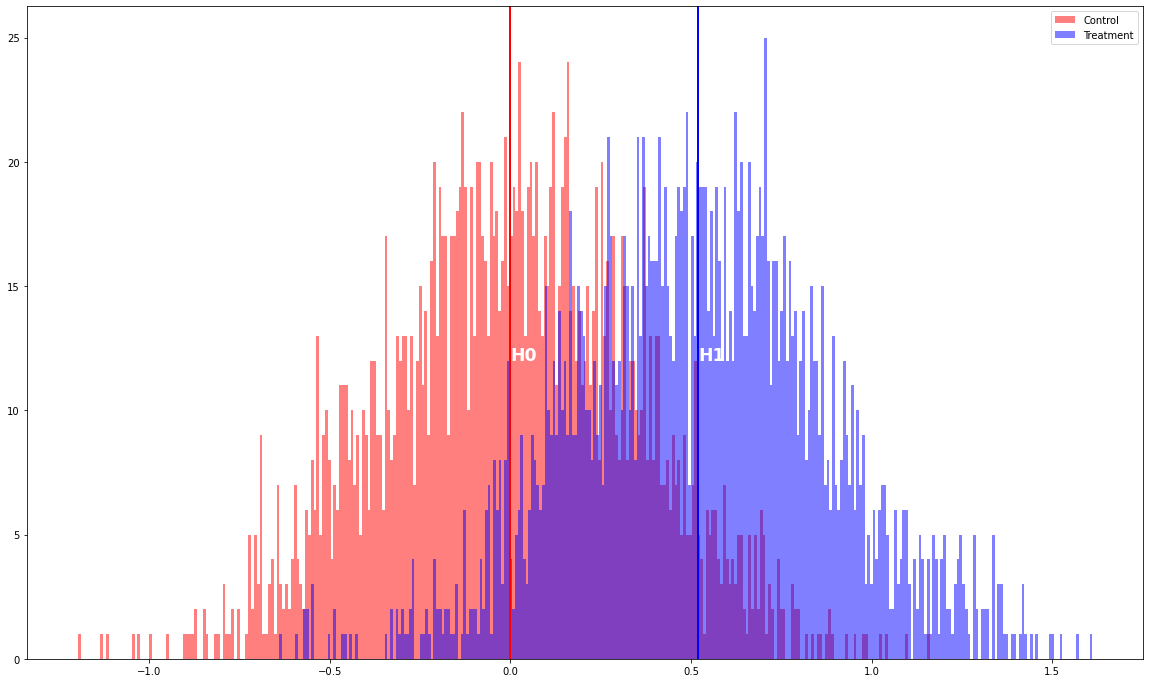

In [97]:
ab_test.plot()

# Кейс №7. Выделение групп.

In [433]:
df = pd.read_csv('./data/ab_data.csv')

In [434]:
df["moda_city"] = np.random.randint(1, 5, df.shape[0])
df["moda_city"] = df["moda_city"].astype(str)
df["country"] = np.random.randint(1, 3, df.shape[0])
df["id"] = df.index

In [435]:
split_builder_params = SplitBuilderParams(
    map_group_names_to_sizes={
        'control': None,
        'target': None
    },
    main_strata_col = "moda_city",
    split_metric_col = "height_now",
    id_col = "id",
    cols = ["height_prev"],
    cat_cols=["country"],
    pvalue=0.05,
    n_bins = 6,
    min_cluster_size = 100
)

In [436]:
split_builder = SplitBuilder(df, split_builder_params)

In [439]:
split = split_builder.collect()

In [440]:
split.head()

,height_now,height_prev,weight_now,weight_prev,noise_now,noise_prev,groups,id,moda_city,country,numerator,denominator,conversion,strata,group_name
0,172.470442,166.382868,163.648256,173.422115,5.644384,-1.923929,A,0,4,0.499485,3,2,1,41-1,target
1,178.610565,173.386388,173.195935,180.831845,11.664751,2.711829,B,1,2,0.499485,1,4,1,24-1,target
2,180.382301,178.563579,174.520065,181.571024,7.183178,-0.453939,A,2,2,0.500515,2,2,1,25-1,target
3,180.954018,179.732080,175.731245,182.840388,-4.682656,6.358723,B,3,2,0.500515,3,2,0,25-1,target
4,167.590042,167.684244,166.109779,170.189261,9.134517,-1.153977,B,4,4,0.499485,3,2,1,40-1,target


# Кейс №8. Препилот для непрерывной метрики.

In [690]:
df = pd.read_csv('./data/ab_data.csv')
df = df.sample(n=20_000, random_state=1)

In [691]:
data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    control_name='A',
    treatment_name='B',
    strata_col='country', 
    target='height_now', 
    target_flg='bought', 
    predictors=['weight_now'], 
    numerator='clicks', 
    denominator='sessions', 
    covariate='height_prev', 
    target_prev='height_prev', 
    predictors_prev=['weight_prev'], 
    is_grouped=True
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided', 
    strata='country', 
    strata_weights={1: 0.8, 2: 0.2}, 
    metric_type='solid', 
    metric_name='mean', 
    metric=np.mean, 
    n_boot_samples=100, 
    n_buckets=50
)

ab_params = ABTestParams(data_params, hypothesis_params)

In [692]:
experiment_params = MdeParams(
    metrics_names=['height_now'],
    injects=[1.0001,1.0002,1.0003],
    min_group_size=5000, 
    max_group_size=10000, 
    step=1000,
    variance_reduction=None,
    use_buckets=False,
    stat_test=ABTest.test_boot_confint,
    iterations_number=10,
    max_beta_score=0.9,
    min_beta_score=0.02,
)

In [693]:
prepilot = MdeResearchBuilder(df, ab_params,
                                  experiment_params,
                                  split_builder_params)

In [694]:
beta, alpha = prepilot.collect()

In [695]:
beta

split_rate       (5000, 5000) (6000, 6000) (7000, 7000) (8000, 8000)  \
metric     MDE                                                         
height_now 0.01%        >=0.9        >=0.9        >=0.9        >=0.9   
           0.02%        >=0.9        >=0.9        >=0.9        >=0.9   
           0.03%        >=0.9        >=0.9        >=0.9        >=0.9   

split_rate       (9000, 9000) (10000, 10000)  
metric     MDE                                
height_now 0.01%        >=0.9          >=0.9  
           0.02%        >=0.9          >=0.9  
           0.03%        >=0.9          >=0.9

In [696]:
alpha

split_rate,"(5000, 5000)","(6000, 6000)","(7000, 7000)","(8000, 8000)","(9000, 9000)","(10000, 10000)"
metric,,,,,,
height_now,0.0,0.0,0.0,0.0,0.0,0.0


# Кейс №9. Препилот для непрерывной метрики со снижением дисперсии.

In [697]:
df = pd.read_csv('./data/ab_data.csv')
df = df.sample(n=20_000, random_state=1)

In [698]:
hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided',  
    strata='country', 
    strata_weights={'US': 0.8, 'UK': 0.2}, 
    metric_type='solid', 
    metric_name='mean', 
    metric=np.mean, 
    n_boot_samples=200, 
    n_buckets=50
)

ab_params = ABTestParams(data_params, hypothesis_params)

In [705]:
prepilot_params = MdeParams(
    metrics_names=['height_now'],
    injects=[1.00046,1.00048,1.0005,1.001],
    min_group_size=5000, 
    max_group_size=10000, 
    step=1000,
    variance_reduction = ABTest.cuped,
    use_buckets = False,
    stat_test = ABTest.test_boot_confint,
    iterations_number = 10,
    max_beta_score=0.9,
    min_beta_score=0.02,
)

In [706]:
prepilot = MdeResearchBuilder(df, ab_params,
                                     prepilot_params,
                                     split_builder_params)

In [707]:
beta, alpha = prepilot.collect()

In [708]:
beta

split_rate        (5000, 5000) (6000, 6000) (7000, 7000) (8000, 8000)  \
metric     MDE                                                          
height_now 0.046%          0.2          0.1          0.1          0.2   
           0.048%          0.2          0.1          0.1          0.1   
           0.05%           0.1          0.1          0.1          0.2   
           0.1%         <=0.02       <=0.02       <=0.02       <=0.02   

split_rate        (9000, 9000) (10000, 10000)  
metric     MDE                                 
height_now 0.046%          0.1            0.1  
           0.048%       <=0.02         <=0.02  
           0.05%        <=0.02         <=0.02  
           0.1%         <=0.02         <=0.02

In [709]:
alpha

split_rate,"(5000, 5000)","(6000, 6000)","(7000, 7000)","(8000, 8000)","(9000, 9000)","(10000, 10000)"
metric,,,,,,
height_now,0.1,0.0,0.0,0.0,0.0,0.0


# Кейс №10. Препилот для бинарной метрики.

In [782]:
df = pd.read_csv('./data/ab_data.csv')
df = df.sample(n=30_000, random_state=1)
df.head()

,height_now,height_prev,weight_now,weight_prev,noise_now,noise_prev,groups,id,moda_city,country,numerator,denominator,conversion
49673,176.962204,173.282588,168.286558,178.545051,8.332472,0.749710,B,49673,2,1,3,3,1
171551,167.719994,164.153443,159.805620,169.937810,6.185760,2.257602,A,171551,4,1,1,2,1
5506,173.478204,172.284449,168.578427,175.216619,7.729058,6.635701,B,5506,2,1,1,2,1
38370,174.789978,172.517970,168.646945,177.518410,9.830704,-1.382761,A,38370,3,1,4,3,1
36930,171.939344,172.241240,166.103368,175.124307,5.606161,6.901354,B,36930,4,2,4,3,1


In [783]:
data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    strata_col='country', 
    target='conversion', 
    target_flg='conversion', 
    predictors=['weight_now'], 
    numerator='numerator', 
    denominator='denominator', 
    covariate='height_prev', 
    target_prev='height_prev', 
    predictors_prev=['weight_prev'], 
    is_grouped=True
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided', 
    strata='country', 
    strata_weights={'US': 0.8, 'UK': 0.2}, 
    metric_type='binary', 
    metric_name='mean', 
    metric=np.mean, 
    n_boot_samples=200, 
    n_buckets=50
)

ab_params = ABTestParams(data_params, hypothesis_params)

In [784]:
split_builder_params = SplitBuilderParams(
    map_group_names_to_sizes={
        'control': None,
        'target': None
    },
    main_strata_col = "moda_city",
    split_metric_col = "height_now",
    id_col = "id",
    cols = ["height_prev"],
    cat_cols=["country"],
    pvalue=0.05,
    n_bins = 6,
    min_cluster_size = 500
)

### Препилот без бакетирования

In [801]:
prepilot_params = MdeParams(
    metrics_names=['conversion'],
    injects=[1.001,1.005,1.01],
    min_group_size=2000, 
    max_group_size=10000, 
    step=100,
    variance_reduction = None,
    use_buckets = False,
    stat_test = ABTest.test_z_proportions,
    iterations_number = 5,
    max_beta_score=0.9,
    min_beta_score=0.01,
)

prepilot = MdeResearchBuilder(df, ab_params,
                                  prepilot_params,
                                  split_builder_params)

In [802]:
%%time 
beta, alpha = prepilot.collect()

CPU times: user 2min 48s, sys: 29.4 s, total: 3min 18s
Wall time: 3min 42s


In [803]:
beta

split_rate      (2000, 2000) (2100, 2100) (2200, 2200) (2300, 2300)  \
metric     MDE                                                        
conversion 0.1%        >=0.9        >=0.9        >=0.9          0.8   
           0.5%          0.4        >=0.9          0.8          0.6   
           1.0%          0.4          0.8          0.2          0.2   

split_rate      (2400, 2400) (2500, 2500) (2600, 2600) (2700, 2700)  \
metric     MDE                                                        
conversion 0.1%        >=0.9        >=0.9          0.8        >=0.9   
           0.5%          0.8        >=0.9          0.8        >=0.9   
           1.0%          0.2          0.6          0.6          0.8   

split_rate      (2800, 2800) (2900, 2900)  ... (9100, 9100) (9200, 9200)  \
metric     MDE                             ...                             
conversion 0.1%          0.8        >=0.9  ...        >=0.9        >=0.9   
           0.5%          0.6        >=0.9  ...          0.6          0.4   
           1.0%          0.4          0.8  ...       <=0.01       <=0.01   

split_rate      (9300, 9300) (9400, 9400) (9500, 9500) (9600, 9600)  \
metric     MDE                                                        
conversion 0.1%        >=0.9        >=0.9        >=0.9        >=0.9   
           0.5%          0.8          0.4          0.2          0.8   
           1.0%       <=0.01       <=0.01       <=0.01       <=0.01   

split_rate      (9700, 9700) (9800, 9800) (9900, 9900) (10000, 10000)  
metric     MDE                                                         
conversion 0.1%        >=0.9        >=0.9        >=0.9          >=0.9  
           0.5%          0.6          0.6          0.6            0.6  
           1.0%       <=0.01       <=0.01       <=0.01         <=0.01  

[3 rows x 81 columns]

In [804]:
alpha

split_rate,"(2000, 2000)","(2100, 2100)","(2200, 2200)","(2300, 2300)","(2400, 2400)","(2500, 2500)","(2600, 2600)","(2700, 2700)","(2800, 2800)","(2900, 2900)",...,"(9100, 9100)","(9200, 9200)","(9300, 9300)","(9400, 9400)","(9500, 9500)","(9600, 9600)","(9700, 9700)","(9800, 9800)","(9900, 9900)","(10000, 10000)"
metric,,,,,,,,,,,,,,,,,,,,,
conversion,0.0,0.0,0.0,0.2,0.0,0.0,0.2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0


### Препилот с бакетированием

In [805]:
prepilot_params = MdeParams(
    metrics_names=['conversion'],
    injects=[1.001,1.005,1.01],
    min_group_size=2000, 
    max_group_size=10000, 
    step=100,
    variance_reduction = None,
    use_buckets = True,
    stat_test = ABTest.test_z_proportions,
    iterations_number = 5,
    max_beta_score=0.9,
    min_beta_score=0.01,
)

prepilot = MdeResearchBuilder(df, ab_params,
                                  prepilot_params,
                                  split_builder_params)

In [806]:
%%time 
beta, alpha = prepilot.collect()

CPU times: user 2min 55s, sys: 30 s, total: 3min 25s
Wall time: 3min 59s


In [807]:
beta

split_rate      (2000, 2000) (2100, 2100) (2200, 2200) (2300, 2300)  \
metric     MDE                                                        
conversion 0.1%          0.8        >=0.9        >=0.9        >=0.9   
           0.5%          0.8          0.8        >=0.9        >=0.9   
           1.0%          0.8          0.2          0.8          0.2   

split_rate      (2400, 2400) (2500, 2500) (2600, 2600) (2700, 2700)  \
metric     MDE                                                        
conversion 0.1%        >=0.9        >=0.9        >=0.9        >=0.9   
           0.5%          0.8          0.8        >=0.9        >=0.9   
           1.0%          0.6          0.4        >=0.9          0.6   

split_rate      (2800, 2800) (2900, 2900)  ... (9100, 9100) (9200, 9200)  \
metric     MDE                             ...                             
conversion 0.1%          0.6        >=0.9  ...        >=0.9        >=0.9   
           0.5%          0.6          0.8  ...          0.4          0.6   
           1.0%          0.2          0.8  ...       <=0.01       <=0.01   

split_rate      (9300, 9300) (9400, 9400) (9500, 9500) (9600, 9600)  \
metric     MDE                                                        
conversion 0.1%        >=0.9        >=0.9        >=0.9        >=0.9   
           0.5%          0.6        >=0.9          0.8          0.8   
           1.0%       <=0.01       <=0.01       <=0.01       <=0.01   

split_rate      (9700, 9700) (9800, 9800) (9900, 9900) (10000, 10000)  
metric     MDE                                                         
conversion 0.1%        >=0.9        >=0.9        >=0.9          >=0.9  
           0.5%          0.8        >=0.9        >=0.9            0.6  
           1.0%       <=0.01       <=0.01       <=0.01         <=0.01  

[3 rows x 81 columns]

In [808]:
alpha

split_rate,"(2000, 2000)","(2100, 2100)","(2200, 2200)","(2300, 2300)","(2400, 2400)","(2500, 2500)","(2600, 2600)","(2700, 2700)","(2800, 2800)","(2900, 2900)",...,"(9100, 9100)","(9200, 9200)","(9300, 9300)","(9400, 9400)","(9500, 9500)","(9600, 9600)","(9700, 9700)","(9800, 9800)","(9900, 9900)","(10000, 10000)"
metric,,,,,,,,,,,,,,,,,,,,,
conversion,0.4,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.4,0.0,...,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0


# Кейс №11. Линеаризация

In [255]:
df = pd.read_csv('./data/ab_data.csv')
df.head()

,height_now,height_prev,weight_now,weight_prev,noise_now,noise_prev,groups,id,moda_city,country,numerator,denominator,conversion
0,172.470442,166.382868,163.648256,173.422115,5.644384,-1.923929,A,0,3,2,3,2,1
1,178.610565,173.386388,173.195935,180.831845,11.664751,2.711829,B,1,2,2,1,4,1
2,180.382301,178.563579,174.520065,181.571024,7.183178,-0.453939,A,2,3,1,2,2,1
3,180.954018,179.732080,175.731245,182.840388,-4.682656,6.358723,B,3,4,1,3,2,0
4,167.590042,167.684244,166.109779,170.189261,9.134517,-1.153977,B,4,2,1,3,2,1


In [256]:
data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    control_name='A',
    treatment_name='B',
    strata_col='country', 
    target='conversion', 
    target_flg='conversion', 
    predictors=['weight_now'], 
    numerator='numerator', 
    denominator='denominator', 
    covariate='height_prev', 
    target_prev='height_prev', 
    predictors_prev=['weight_prev'], 
    is_grouped=False
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='two-sided', 
    strata='country', 
    strata_weights={'US': 0.8, 'UK': 0.2}, 
    metric_type='solid', 
    metric_name='mean', 
    metric=np.mean, 
    n_boot_samples=200, 
    n_buckets=50
)

ab_params = ABTestParams(data_params, hypothesis_params)

In [257]:
ab_test = ABTest(df, ab_params)
ab_test_1 = ab_test.linearization()
ab_test_2 = ab_test_1.cuped()

In [258]:
df_linear = pd.DataFrame(data={
    'id': list(range(0, len(ab_test_1._ABTest__dataset.numerator_denominator), 1)),
    'ratio_linear': ab_test_1._ABTest__dataset.numerator_denominator
})

In [259]:
df_grouped = df.groupby(by=['id', 'groups'], as_index=False).agg({
                'numerator': 'sum',
                'denominator': 'sum'
            })
df_grouped['ratio_real'] = df_grouped.numerator / df_grouped.denominator
df_grouped = df_grouped.merge(df_linear, how='left', on='id')
df_grouped.head()

,id,groups,numerator,denominator,ratio_real,ratio_linear
0,0,A,3,2,1.50,0.9978
1,1,B,1,4,0.25,-3.0044
2,2,A,2,2,1.00,-0.0022
3,3,B,3,2,1.50,0.9978
4,4,B,3,2,1.50,0.9978


In [260]:
df_grouped[['ratio_real', 'ratio_linear']].corr()

,ratio_real,ratio_linear
ratio_real,1.000000,0.901641
ratio_linear,0.901641,1.000000


In [223]:
import seaborn as sns

plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df_grouped,
            x='ratio_real', y='ratio_linear',
            hue='groups', s=80)
plt.legend()
plt.xlabel('ratio_real', fontsize=16)
plt.ylabel('ratio_linear', fontsize=16)
# plt.show()
plt.savefig('linearization.png', dpi=300, bbox_inches='tight')
plt.close()

In [228]:
ab_test_1.params.data_params.transforms

array(['linearization'], dtype='<U32')

In [229]:
ab_test.params.data_params.transforms

array([], dtype=float64)

In [263]:
print(ab_test_2.report())


        Parameters of experiment:
        - Metric: mean.
        - Errors: alpha = 0.05, beta = 0.2.
        - Alternative: two-sided.
        
        Control group:
        - Observations: 99684
        - Mean: 0.0000
        - Median: -0.0027
        - 25th quantile: -1.0040
        - 75th quantile: 0.9985
        - Minimum: -3.0094
        - Maximum: 3.0029
        
        Treatment group:
        - Observations: 100316
        - Mean: 0.0011
        - Median: -0.0027
        - 25th quantile: -1.0039
        - 75th quantile: 0.9985
        - Minimum: -3.0093
        - Maximum: 3.0033
        
        Transformations applied: linearization -> cuped.
        Number of bootstrap iterations: 200. 
        
        
        Following statistical tests are used:
        - Welch's t-test: 0.15, p-value = 0.8786, H0 is not rejected.
        - Mann Whitney's U-test: 4998264011.00, p-value = 0.8961, H0 is not rejected.
        - Bootstrap test: H0 is not rejected.
        
        All thr

# Кейс №12. Анализ эксперимента с помощью пост-стратификации

In [682]:
df = pd.read_csv('./data/ab_data.csv')
df['height_now'].where(df['groups'] == 'A',
                       df['height_now'] * 1.006,
                       axis=0,
                       inplace=True)
# df['id'] = np.random.randint(0, 150_000, df.shape[0])
# df = df.drop_duplicates(['id'])

df.loc[df.country == 1, 'country'] = 'France'
df.loc[df.country == 2, 'country'] = 'Spain'

df.loc[df.country == 'Spain', 'height_now'] = df.loc[df.country == 'Spain', 
                                                     'height_now'] + np.random.randint(0, 20, df.loc[df.country == 'Spain'].shape[0])

df.head()

,height_now,height_prev,weight_now,weight_prev,noise_now,noise_prev,groups,id,moda_city,country,numerator,denominator,conversion
0,186.470442,166.382868,163.648256,173.422115,5.644384,-1.923929,A,0,3,Spain,3,2,1
1,182.682229,173.386388,173.195935,180.831845,11.664751,2.711829,B,1,2,Spain,1,4,1
2,180.382301,178.563579,174.520065,181.571024,7.183178,-0.453939,A,2,3,France,2,2,1
3,182.039742,179.732080,175.731245,182.840388,-4.682656,6.358723,B,3,4,France,3,2,0
4,168.595582,167.684244,166.109779,170.189261,9.134517,-1.153977,B,4,2,France,3,2,1


In [684]:
df.country.unique()

array(['Spain', 'France'], dtype=object)

In [685]:
df.country.value_counts()

Spain     100211
France     99789
Name: country, dtype: int64

In [707]:
df.groupby(['groups', 'country']).height_now.agg(['mean', 'count', 'var'])

mean  count        var
groups country                              
A      France   174.990129  49627  24.823831
       Spain    184.513655  50057  58.111197
B      France   176.038852  50162  25.099130
       Spain    185.527235  50154  58.122163

In [714]:
data_params = DataParams(
    id_col='id', 
    group_col='groups', 
    strata_col='country', 
    target='height_now', 
    target_flg='bought', 
    predictors=['weight_now'], 
    numerator='clicks', 
    denominator='sessions', 
    covariate='height_prev', 
    target_prev='height_prev', 
    predictors_prev=['weight_prev'], 
    is_grouped=False
)

hypothesis_params = HypothesisParams(
    alpha=0.05, 
    beta=0.2, 
    alternative='greater', 
    strata='country', 
    strata_weights={'Spain': 0.4, 'France': 0.6}, 
    metric_type='solid', 
    metric_name='mean', 
    metric=np.mean, 
    n_boot_samples=200, 
    n_buckets=2000
)

ab_params = ABTestParams(data_params, hypothesis_params)

In [715]:
ab_test = ABTest(df, ab_params)

In [716]:
ab_test.test_post_strat_confint()

179.77243247420418
178.79701798299263
180.7826649825664
179.80483243247767
SRS
1.0363
0.0007
PS
1.0094
0.0011
Relation
1.0266
0.6634


{'stat': None, 'p-value': None, 'result': 1}